In [1]:
%matplotlib inline

In [2]:
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

from numpy import expand_dims
from fastai2.vision.all import load_learner
import matplotlib.pyplot as plt
import os
import json


In [3]:
BASE_DIR = r'datasets/malaria_culture_data'

In [4]:
TRAINING_JSON = os.path.join(BASE_DIR, 'training.json')

TRAINING_IMG_COUNT = 100
TESTING_IMG_COUNT = 50

In [5]:
class PredictionConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [6]:
def get_full_path(some_path):
    image_path = some_path.replace('/', '\\') if os.name == 'nt' else some_path
    image_path = os.path.abspath(os.path.expanduser(image_path))
    return image_path

In [7]:
class CellCultureDataset(Dataset):
    def load_json_data(self):
        self.data = json.load(open(TRAINING_JSON))
    def load_dataset(self, is_train=True):
        
        self.add_class("dataset", 1, "cellculture")
        count = -1
        for training_image in self.data:
            count += 1
            if is_train and count > TRAINING_IMG_COUNT:
                continue
            if not is_train and count <= TRAINING_IMG_COUNT:
                continue
            if count > TRAINING_IMG_COUNT + TESTING_IMG_COUNT:
                break
            img_id = training_image['image']['pathname'][8:-4]
            image_path = training_image['image']['pathname'][1:]
            image_path = os.path.join(BASE_DIR, image_path)
            image_path = get_full_path(image_path)
            self.add_image('dataset', image_id=img_id, path=image_path, annotation=training_image)

In [12]:
def get_predicted_cells(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        local_img = os.path.join(BASE_DIR, img['image']['pathname'][1:])
        local_img = get_full_path(local_img)
        image_path = get_full_path(image_path)
        if local_img == image_path:
            wanted_image = local_img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = wanted_image
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    detected_cells = []
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        detected_cells.append(image[y1:y1+height, x1:x1+width])
    return detected_cells
    
def get_predicted_cells_from_image(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    return get_predicted_cells(model, cfg, image_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/My Drive/separated.rar" /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/separated/uninfected/100.png                         44%  OK 
Extracting  /content/separated/uninfected/1000.png                        44%  OK 
Extracting  /content/separated/uninfected/1001.png                        44%  OK 
Extracting  /content/separated/uninfected/1002.png                        44%  OK 
Extracting  /content/separated/uninfected/1003.png                        44%  OK 
Extracting  /content/separated/uninfected/1004.png                        44%  OK 
Extracting  /content/separated/uninfected/1005.png                        44%  OK 
Extracting  /content/separated/uninfected/1006.png                        44%  OK 
Extracting  /content/separated/uninfected/1007.png                        44%  OK 
Extracting  /content/separated/uninfected/1008.png                        44%  OK 
Extracting  /content/separate

51 cells:


/home/daniel/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


('uninfected', tensor(1), tensor([5.9591e-05, 9.9994e-01]))


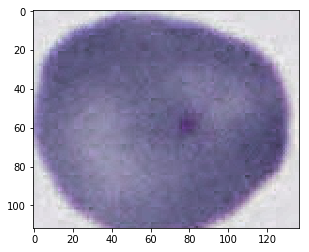

('uninfected', tensor(1), tensor([5.3575e-05, 9.9995e-01]))


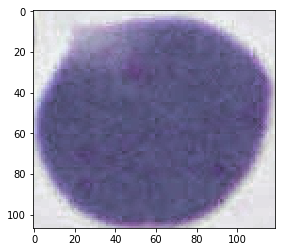

('uninfected', tensor(1), tensor([0.0169, 0.9831]))


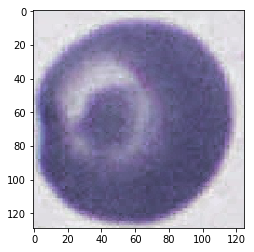

('uninfected', tensor(1), tensor([5.0301e-05, 9.9995e-01]))


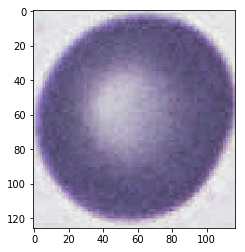

('uninfected', tensor(1), tensor([0.0155, 0.9845]))


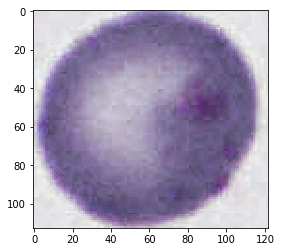

('uninfected', tensor(1), tensor([5.7981e-05, 9.9994e-01]))


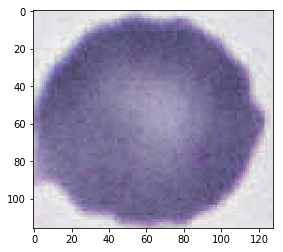

('uninfected', tensor(1), tensor([0.0014, 0.9986]))


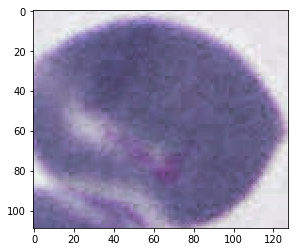

('uninfected', tensor(1), tensor([0.0073, 0.9927]))


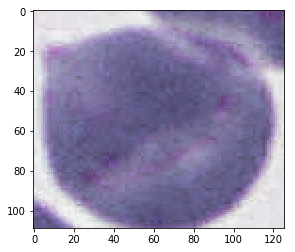

('uninfected', tensor(1), tensor([2.0387e-04, 9.9980e-01]))


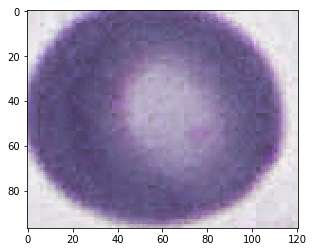

('uninfected', tensor(1), tensor([2.5785e-04, 9.9974e-01]))


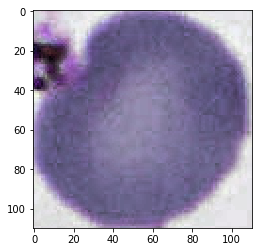

('uninfected', tensor(1), tensor([6.0978e-04, 9.9939e-01]))


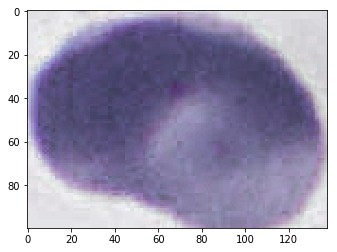

('uninfected', tensor(1), tensor([0.0021, 0.9979]))


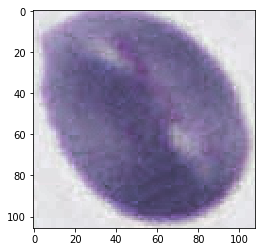

('uninfected', tensor(1), tensor([6.7669e-05, 9.9993e-01]))


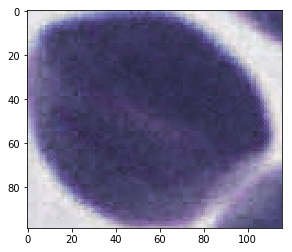

('uninfected', tensor(1), tensor([3.0079e-04, 9.9970e-01]))


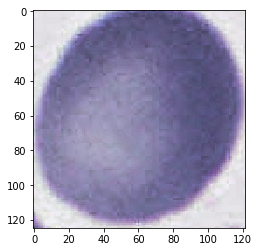

('uninfected', tensor(1), tensor([6.8176e-04, 9.9932e-01]))


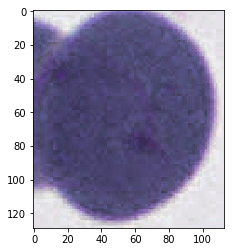

('uninfected', tensor(1), tensor([9.7201e-05, 9.9990e-01]))


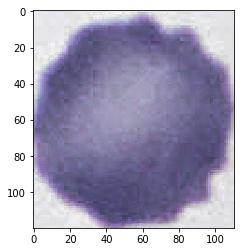

('uninfected', tensor(1), tensor([0.0011, 0.9989]))


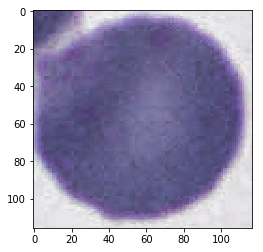

('uninfected', tensor(1), tensor([8.1188e-05, 9.9992e-01]))


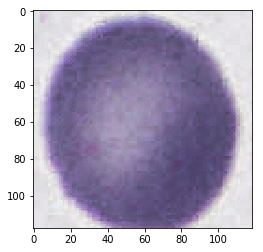

('uninfected', tensor(1), tensor([0.0017, 0.9983]))


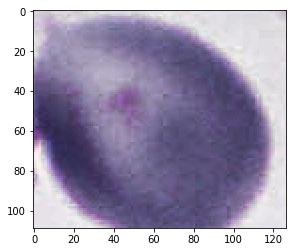

('uninfected', tensor(1), tensor([4.9862e-05, 9.9995e-01]))


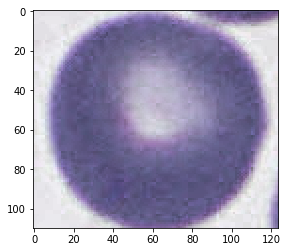

('uninfected', tensor(1), tensor([0.0012, 0.9988]))


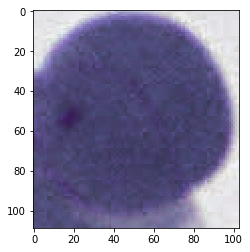

('uninfected', tensor(1), tensor([5.9289e-04, 9.9941e-01]))


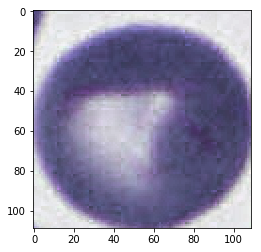

('uninfected', tensor(1), tensor([0.0018, 0.9982]))


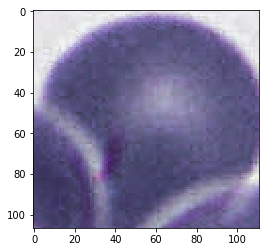

('uninfected', tensor(1), tensor([9.9530e-04, 9.9900e-01]))


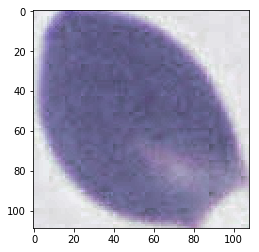

('uninfected', tensor(1), tensor([2.0236e-04, 9.9980e-01]))


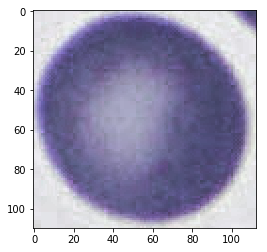

('uninfected', tensor(1), tensor([0.0014, 0.9986]))


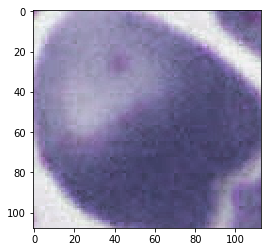

('uninfected', tensor(1), tensor([0.0018, 0.9982]))


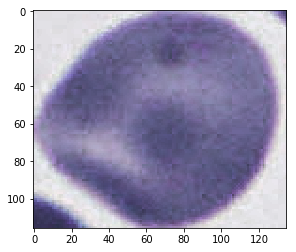

('uninfected', tensor(1), tensor([4.0159e-04, 9.9960e-01]))


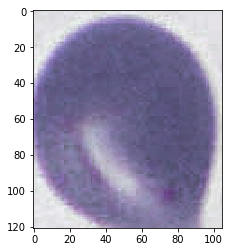

('uninfected', tensor(1), tensor([0.0014, 0.9986]))


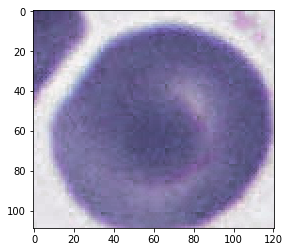

('uninfected', tensor(1), tensor([1.7475e-04, 9.9983e-01]))


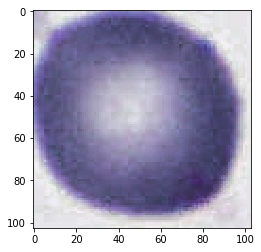

('uninfected', tensor(1), tensor([0.0180, 0.9820]))


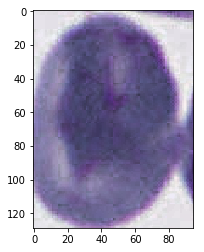

('infected', tensor(0), tensor([1.0000e+00, 3.3855e-07]))


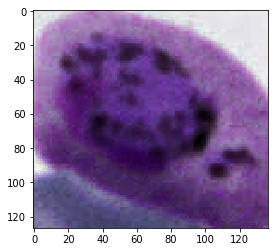

('uninfected', tensor(1), tensor([2.9602e-04, 9.9970e-01]))


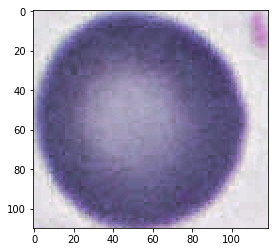

('uninfected', tensor(1), tensor([0.0020, 0.9980]))


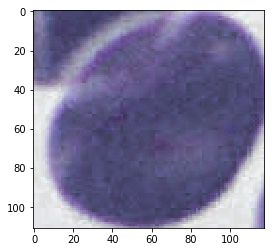

('uninfected', tensor(1), tensor([9.7152e-05, 9.9990e-01]))


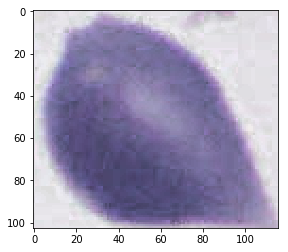

('uninfected', tensor(1), tensor([0.0046, 0.9954]))


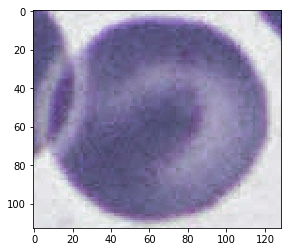

('uninfected', tensor(1), tensor([0.0026, 0.9974]))


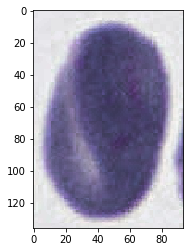

('uninfected', tensor(1), tensor([0.0040, 0.9960]))


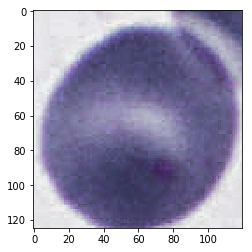

('uninfected', tensor(1), tensor([3.2037e-04, 9.9968e-01]))


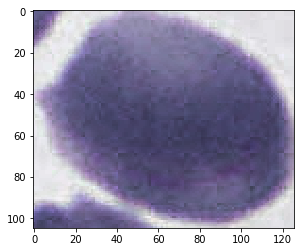

('uninfected', tensor(1), tensor([0.0051, 0.9949]))


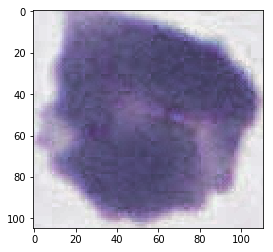

('uninfected', tensor(1), tensor([0.0036, 0.9964]))


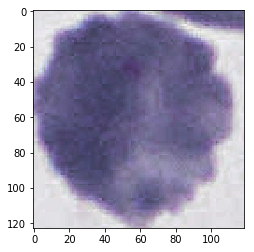

('uninfected', tensor(1), tensor([0.0014, 0.9986]))


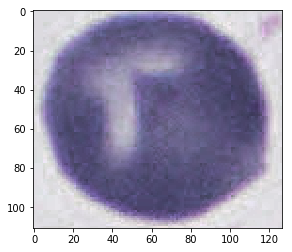

('uninfected', tensor(1), tensor([0.0080, 0.9920]))


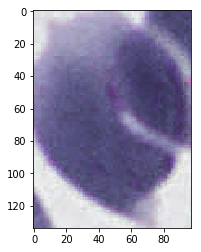

('uninfected', tensor(1), tensor([7.2520e-04, 9.9927e-01]))


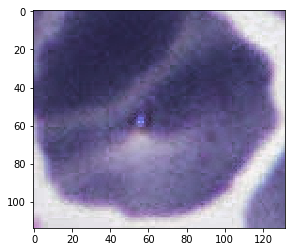

('uninfected', tensor(1), tensor([0.0062, 0.9938]))


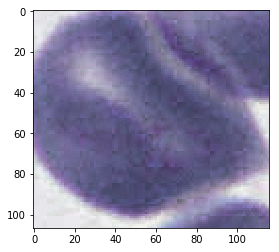

('uninfected', tensor(1), tensor([0.0012, 0.9988]))


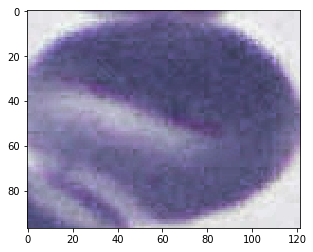

('uninfected', tensor(1), tensor([8.9160e-04, 9.9911e-01]))


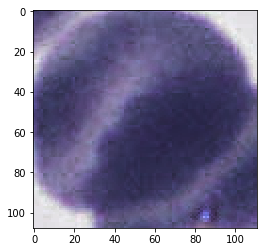

('uninfected', tensor(1), tensor([0.0209, 0.9791]))


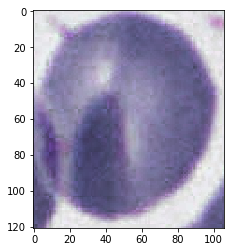

('uninfected', tensor(1), tensor([3.8009e-04, 9.9962e-01]))


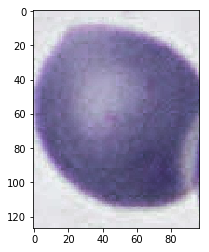

('uninfected', tensor(1), tensor([5.9187e-05, 9.9994e-01]))


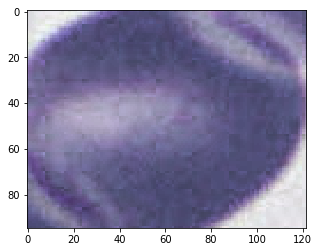

('uninfected', tensor(1), tensor([0.0373, 0.9627]))


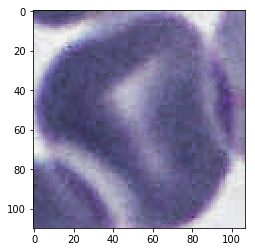

In [14]:
cells = get_predicted_cells_from_image(r"~/repos/OpenUDataScienceProj/Project/datasets/malaria_culture_data/images/06df7bbe-60d4-4f7c-ba4a-5a42ac4be91b.png")
print("%d cells:" % len(cells))

learn = load_learner("xrsnet_34_singlecell_extracted.pkl")


for cell in cells:
    print(learn.predict(cell))
    plt.imshow(cell)
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai2.data.all import *
from fastai2.vision.data import *
from fastai2.vision.all import *

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

import os
print(os.listdir("/content/separated/"))

['uninfected', 'infected']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai2.data.all import *
from fastai2.vision.data import *
from fastai2.vision.all import *

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

import os
print(os.listdir("/content/separated/"))

['uninfected', 'infected']


In [ ]:
splitter = RandomSplitter()
item_tfms = [Resize(224)]
batch_tfms=[*aug_transforms(flip_vert=True,max_zoom=1.2, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [ ]:
data_block = DataBlock(blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

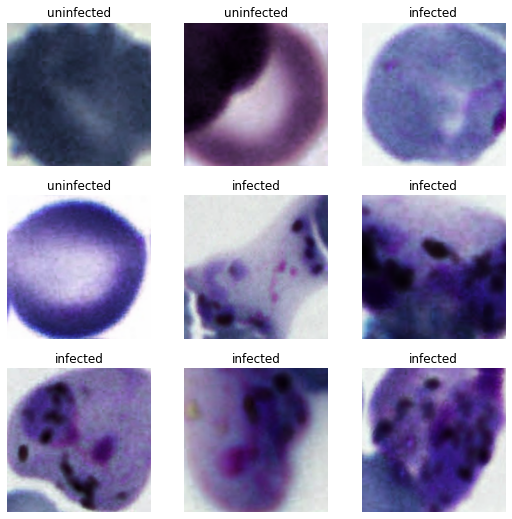

In [ ]:
data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [ ]:
learn = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/checkpoints/xrn50_940.pth


In [ ]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.310712,0.112158,0.964239,00:53


epoch,train_loss,valid_loss,accuracy,time
0,0.134157,0.088701,0.972692,01:12
1,0.132188,0.090635,0.975293,01:11
2,0.111698,0.081708,0.970741,01:12
3,0.107405,0.087055,0.974642,01:11
4,0.086296,0.060701,0.981795,01:11
5,0.074027,0.051664,0.981795,01:11
6,0.078072,0.048478,0.987646,01:11
7,0.069995,0.044149,0.987646,01:10
8,0.055901,0.039483,0.990897,01:11
9,0.057169,0.029635,0.991547,01:11


In [ ]:
learn.save('stage-1')

In [ ]:
learn.export('xrsnet_34_singlecell_extracted.pkl')

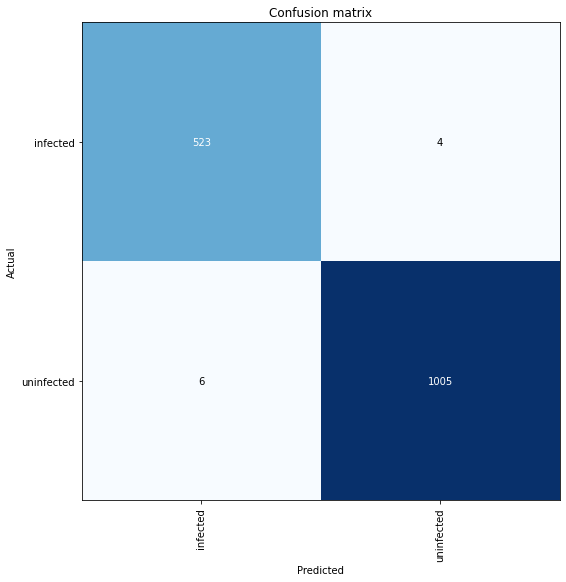

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([1538]), torch.Size([1538, 2]))